In [1]:
!pip install tf-agents

     |████████████████████████████████| 1.1 MB 912 kB/s 
     |████████████████████████████████| 44 kB 1.2 MB/s 


In [2]:
import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_resource_variables()
tf.compat.v1.enable_v2_behavior()
nest = tf.compat.v2.nest

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt

In [3]:
# settings

batch_size = 2

# Functions

In [4]:
batch_size = 5 # @param


def context_sampling_fn(batch_size):

  def _context_sampling_fn():
    return np.random.randint(0, 2, [batch_size, 2]).astype(np.float32)
  return _context_sampling_fn

In [5]:
class CalculateReward(object):
    
    """A class that acts as linear reward function when called."""
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
    def __call__(self, x):
        mu = np.dot(x, self.theta)
        #return np.random.normal(mu, self.sigma)
        return (mu > 0) + 0


In [6]:
arm0_param = [2, -1]
arm1_param = [1, -1] 
arm2_param = [-1, 1] 
arm3_param = [ 0, 0] 


arm0_reward_fn = CalculateReward(arm0_param, 1)
arm1_reward_fn = CalculateReward(arm1_param, 1)
arm2_reward_fn = CalculateReward(arm2_param, 1)
arm3_reward_fn = CalculateReward(arm3_param, 1)


In [7]:
def compute_optimal_reward(observation):
    expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm3_param, dtype=tf.float32))
    ]
    optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
    
    return optimal_action_reward

## Stationary Stochastic Environment with Linear Payoff Functions

The environment used in this example is the [StationaryStochasticPyEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_py_environment.py). This environment takes as parameter a (usually noisy) function for giving observations (context), and for every arm takes an (also noisy) function that computes the reward based on the given observation. In our example, we sample the context uniformly from a d-dimensional cube, and the reward functions are linear functions of the context, plus some Gaussian noise.

In [8]:

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn, arm3_reward_fn],
        batch_size=batch_size))


## The LinUCB Agent

The agent below implements the [LinUCB](http://rob.schapire.net/papers/www10.pdf) algorithm.

In [9]:
observation_spec = tensor_spec.TensorSpec([2], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

## Regret Metric

Bandits' most important metric is *regret*, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a *baseline_reward_fn* function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [10]:
regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a *driver*, and train the agent on the data.

Note that there are two parameters that together specify the number of steps taken. `num_iterations` specifies how many times we run the trainer loop, while the driver will take `steps_per_loop` steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while some are done by the driver in every step. For example, the agent's `train` function is only called once per iteration. The trade-off here is that if we train more often then our policy is "fresher", on the other hand, training in bigger batches might be more time efficient.

Text(0.5, 0, 'Number of Iterations')

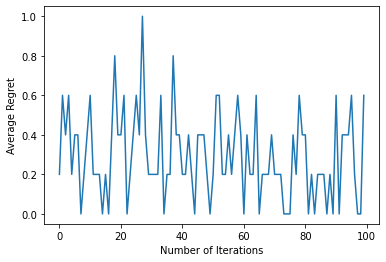

In [11]:
num_iterations = 100 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')